# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import gc
import tensorflow as tf
from tensorflow import keras

# Initial Preprocessing

Before going into feature transformations and imputation, we repeat the preprocessing in the EDA code by merging the datasets, reducing memory usage, and decomposing the timestamp variable.

### Import Data

In [2]:
folder_path = "C:/Users/c21117159/OneDrive - Cardiff University/Documents/Dual Semester/CMT307 - Applied Machine Learning/Coursework 2/Data/"

train = pd.read_csv(folder_path + "train.csv")
test = pd.read_csv(folder_path + "test.csv")

weather_train = pd.read_csv(folder_path + "weather_train.csv")
weather_test = pd.read_csv(folder_path + "weather_test.csv")

building = pd.read_csv(folder_path + "building_metadata.csv")

### Memory Reduction

In [3]:
# https://www.kaggle.com/kernels/scriptcontent/3684066/download

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    #iterating over every column and finding the type of the column
    for col in df.columns:
      if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
      col_type = df[col].dtype
        
        #If the columns is not object
      if col_type != object:
          #Get the minimum and maximum value
            c_min = df[col].min()
            c_max = df[col].max()
            #If the type is int
            if str(col_type)[:3] == 'int':
              #If the min max values lies with thin the range of int8 type then assign the type as int8
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
              #If the min max values lies with thin the range of int16 type then assign the type as int16 
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
              #If the min max values lies with thin the range of int32 type then assign the type as int32
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
              #If the min max values lies with thin the range of int64 type then assign the type as int64
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
              #If the min max values lies with thin the range of float16 type then assign the type as float16
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
              #If the min max values lies with thin the range of float32 type then assign the type as float32
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
      else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
train = reduce_mem_usage(train, use_float16=True)
weather_train = reduce_mem_usage(weather_train, use_float16=True)

test = reduce_mem_usage(test, use_float16=True)
weather_test = reduce_mem_usage(weather_test, use_float16=True)

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.84 MB
Decreased by 71.8%
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.59 MB
Decreased by 73.1%
Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 358.53 MB
Decreased by 71.8%
Memory usage of dataframe is 19.04 MB
Memory usage after optimization is: 5.13 MB
Decreased by 73.0%


### Merging Datasets

In [5]:
df_train = train.merge(building, how='left', on='building_id')
df_train = df_train.merge(weather_train, how='left', on=['site_id','timestamp'])

In [6]:
# Delete original datasets to improve memory usage:
del train,weather_train

### Timestamp Decomposition

In [7]:
def break_datetime(df):
  df['timestamp']= pd.to_datetime(df['timestamp'])
  df['hour']= np.uint8(df['timestamp'].dt.hour)
  df['day']= np.uint16(df['timestamp'].dt.day)
  df['dayofweek']= np.uint8(df['timestamp'].dt.dayofweek)
  df['month']= np.uint8(df['timestamp'].dt.month)
  df['dayofyear']= np.uint16(df['timestamp'].dt.dayofyear)
 
  df['year']= np.uint16(df['timestamp'].dt.year)
  return df

In [8]:
df_train = break_datetime(df_train)

In [9]:
df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 1542.69 MB
Memory usage after optimization is: 1022.14 MB
Decreased by 33.7%


# Preparing Data for Modelling

In [10]:
df = df_train.copy()

Firstly, we remove the outlying building found in the EDA (building_id = 1099)

In [11]:
df = df.query("building_id != 1099")

Then, we extract the target variable into a separate variable.

In [12]:
y = pd.DataFrame(df.pop("meter_reading"))

Now, we create a pipeline for imputing missing values, encoding categorical variables, and scaling numeric variables, including the target variable.

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

cat_features = ["meter","site_id","primary_use","hour","dayofweek","month"]
cat_transformer = Pipeline(
    [
        ("cat_imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder())
    ]
)


num_features = ["square_feet","air_temperature","cloud_coverage","dew_temperature","precip_depth_1_hr",
               "sea_level_pressure","wind_direction","wind_speed"]
num_transformer = Pipeline(
    [
        ("num_imputer", SimpleImputer(strategy="median")),
        ("num_scaler", MinMaxScaler())
    ]
)


preprocessor = ColumnTransformer(
    [
        ("categoricals", cat_transformer, cat_features),
        ("numericals", num_transformer, num_features)
    ]
)

X = preprocessor.fit_transform(df)

y_scaler = MinMaxScaler()
y = np.ravel(y_scaler.fit_transform(y))

gc.collect()

46

In [14]:
print("""
Shapes:

X: {}
y: {}
""".format(X.shape, y.shape))


Shapes:

X: (20198534, 87)
y: (20198534,)



# Modelling

We attempted 4 modelling techniques:

- Linear regression.
- Support vector machine (SVM).
- Random forest.
- LSTM recurrent neural network.

### Splitting Data

We split the data into training and validation data by selecting a proportion of the building IDs and extracting these from X and y.

In [15]:
train_prop = 0.7

train_buildings = df.building_id.unique()[:int(train_prop * len(df.building_id.unique()))]

train_val_split_index = df.loc[df.building_id.isin(train_buildings)].shape[0]

X_train = X[:train_val_split_index]
X_val = X[train_val_split_index:]

y_train = y[:train_val_split_index]
y_val = y[train_val_split_index:]

In [16]:
del X, y

In [17]:
print("""
Shapes:

X_train: {}
y_train: {}

X_val: {}
y_val: {}
""".format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))


Shapes:

X_train: (12752470, 87)
y_train: (12752470,)

X_val: (7446064, 87)
y_val: (7446064,)



### Linear Regression

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime

start_time = datetime.now()

lr = LinearRegression().fit(X_train, np.array(y_train))

lr_preds = lr.predict(X_val)

lr_rmse = mean_squared_error(y_val, lr_preds, squared=False)
lr_mae = mean_absolute_error(y_val, lr_preds)
lr_r2 = r2_score(y_val, lr_preds)

print("""
Linear Regression:
RMSE: {}
MAE: {}
R-squared: {}
""".format(lr_rmse.round(4), lr_mae.round(4), lr_r2.round(4)))
print("Time taken to train: ", datetime.now() - start_time)


Linear Regression:
RMSE: 0.0071
MAE: 0.0008
R-squared: 0.0146

Time taken to train:  0:00:27.699847


We can get an idea of the predictions the model makes by selecting a building in the validation data and comparing the predictions and true values.

In [19]:
val_building_id = df.building_id.unique()[df.building_id.unique().shape[0] - 1]

y_val_building = y_scaler.inverse_transform(y_val[-df.loc[df.building_id == val_building_id].shape[0]:].reshape(-1,1))

lr_pred_building = y_scaler.inverse_transform(lr_preds[-df.loc[df.building_id == val_building_id].shape[0]:].reshape(-1,1))

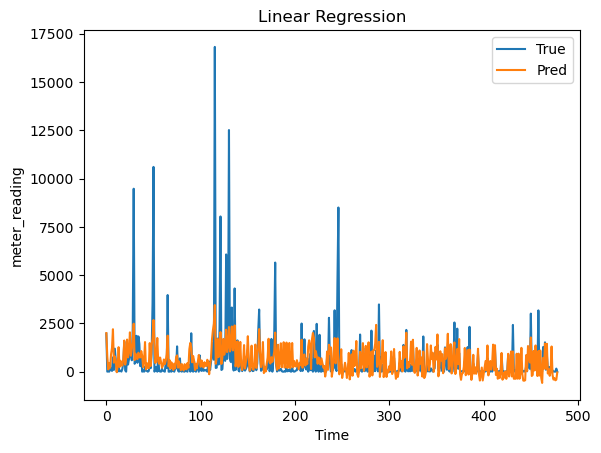

In [20]:
import matplotlib.pyplot as plt

plt.plot(y_val_building, label="True")
plt.plot(lr_pred_building, label="Pred")

plt.title("Linear Regression")
plt.ylabel("meter_reading")
plt.xlabel("Time")
plt.legend()

plt.show()

In [21]:
gc.collect()

3442

### Support Vector Machine (SVM)

In [22]:
from sklearn.svm import SVR

start_time = datetime.now()

svm = SVR().fit(X_train, y_train)

svm_preds = svm.predict(X_val)

svm_rmse = mean_squared_error(y_val, svm_preds, squared=False)
svm_mae = mean_absolute_error(y_val, svm_preds)
svm_r2 = r2_score(y_val, svm_preds)

print("""
Support Vector Machine:
RMSE: {}
MAE: {}
R-squared: {}
""".format(svm_rmse.round(3), svm_mae.round(3), svm_r2.round(3)))
print("Time to train: ", datetime.now() - start_time)


Support Vector Machine:
RMSE: 0.098
MAE: 0.098
R-squared: -187.247

Time to train:  0:00:17.894620


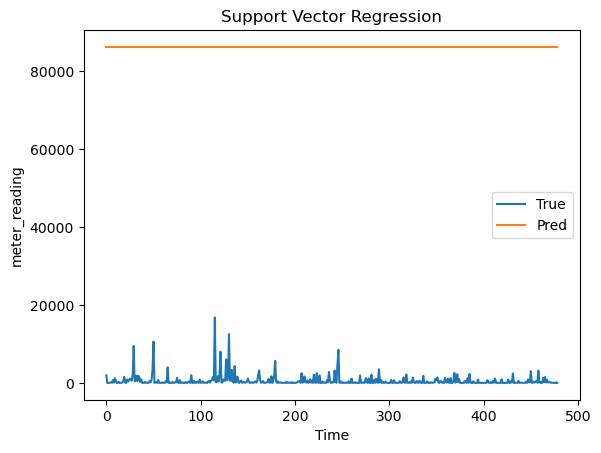

In [23]:
svm_pred_building = y_scaler.inverse_transform(svm_preds[-df.loc[df.building_id == val_building_id].shape[0]:].reshape(-1,1))

plt.plot(y_val_building, label="True")
plt.plot(svm_pred_building, label="Pred")

plt.title("Support Vector Regression")
plt.ylabel("meter_reading")
plt.xlabel("Time")
plt.legend()

plt.show()

In [24]:
print("Max predicted value: ", svm_preds.max())
print("Min predicted value: ", svm_preds.min())

Max predicted value:  0.09803276509046555
Min predicted value:  0.09803276509046555


SVR performs very poorly so we do not explore this option further.

### Random Forest

Before fitting this on the whole dataset, we estimate how long it would take by taking a subsample of the data to fit on and multiplying the time taken accordingly.

In [25]:
from sklearn.ensemble import RandomForestRegressor

subset_size = 1 / 1000
subset = int(X_train.shape[0] * subset_size)

start_time = datetime.now()

rf = RandomForestRegressor(random_state=1, n_jobs=-1).fit(X_train[:subset], y_train[:subset])

rf_preds = rf.predict(X_val[:subset])

print("Esimtated time to train: ", (datetime.now() - start_time) / subset_size)

Esimtated time to train:  3:03:29.735000


The random forest model would take too long to fit on the whole dataset, especially when considering hyperparameter optimisation. Therefore, we take a subsample of the data to train the model on. We have to make sure this is a stratified sample, especially with respect to the building primary use as it would be easy to miss a category if randomly sampling.

In [26]:
from sklearn.utils import resample

sample_size = 20000

df_sample = resample(df_train.query("building_id != 1099"), replace=False, n_samples=sample_size, random_state=1, stratify=df_train.query("building_id != 1099").primary_use).reset_index()

y_sample = pd.DataFrame(df_sample.pop("meter_reading"))
y_sample = np.ravel(y_scaler.fit_transform(y_sample))

X_sample = preprocessor.fit_transform(df_sample)

In [27]:
from sklearn.model_selection import train_test_split

test_size = 0.2

X_train_sample, X_val_sample, y_train_sample, y_val_sample = train_test_split(X_sample, y_sample, test_size=test_size, random_state=1)

print("""
Shapes:

X_train_sample: {}

y_train_sample: {}

X_val_sample: {}

y_val_sample: {}
""".format(X_train_sample.shape, y_train_sample.shape, X_val_sample.shape, y_val_sample.shape))


Shapes:

X_train_sample: (16000, 87)

y_train_sample: (16000,)

X_val_sample: (4000, 87)

y_val_sample: (4000,)



In [28]:
start_time = datetime.now()

rf = RandomForestRegressor(random_state=1, n_jobs=-1).fit(X_train_sample, y_train_sample)

rf_preds = rf.predict(X_val_sample)

rf_rmse = mean_squared_error(y_val_sample, rf_preds, squared=False)
rf_mae = mean_absolute_error(y_val_sample, rf_preds)
rf_r2 = r2_score(y_val_sample, rf_preds)

print("""
Random Forest Regressor:
RMSE: {}
MAE: {}
R-squared: {}
""".format(rf_rmse.round(3), rf_mae.round(3), rf_r2.round(3)))
print("Time to train: ", datetime.now() - start_time)


Random Forest Regressor:
RMSE: 0.014
MAE: 0.002
R-squared: 0.393

Time to train:  0:00:28.860061


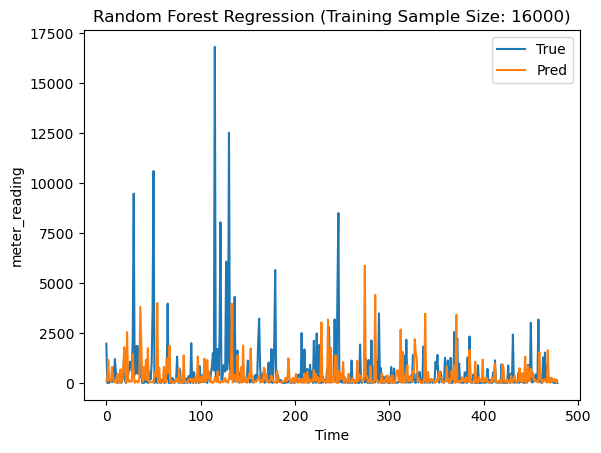

In [29]:
rf_pred_building = y_scaler.inverse_transform(rf_preds[-df.loc[df.building_id == val_building_id].shape[0]:].reshape(-1,1))

plt.plot(y_val_building, label="True")
plt.plot(rf_pred_building, label="Pred")

plt.title("Random Forest Regression (Training Sample Size: " + str(int(sample_size * (1 - test_size))) + ")")
plt.ylabel("meter_reading")
plt.xlabel("Time")
plt.legend()

plt.show()

In [30]:
gc.collect()

6685

We then optimise some hyperparameters of the random forest model. We do so using grid search cv, comparing results using the root mean squared error.

In [31]:
from sklearn.model_selection import GridSearchCV

start_time = datetime.now()

param_grid = {
    'max_depth': [50, 100, 1000, None],
    'min_samples_leaf': [1, 10, 100],
    'min_samples_split': [2, 10, 100],
    'n_estimators': [10, 100, 500, 1000]
}

rf = RandomForestRegressor(random_state=1, n_jobs=-1)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, scoring='r2',  n_jobs=-1)

grid_search.fit(X_train_sample, y_train_sample)

print("\nBest Parameters:\n", grid_search.best_params_)

params = grid_search.best_params_

rf = RandomForestRegressor(max_depth=params["max_depth"],
                          min_samples_leaf=params["min_samples_leaf"],
                          min_samples_split=params["min_samples_split"],
                          n_estimators=params["n_estimators"],
                          random_state=1, n_jobs=-1)

rf.fit(X_train_sample, y_train_sample)

rf_preds = rf.predict(X_val_sample)

rf_rmse = mean_squared_error(y_val_sample, rf_preds, squared=False)
rf_mae = mean_absolute_error(y_val_sample, rf_preds)
rf_r2 = r2_score(y_val_sample, rf_preds)

print("""
Random Forest Regressor:
RMSE: {}
MAE: {}
R-squared: {}
""".format(rf_rmse.round(3), rf_mae.round(3), rf_r2.round(3)))
print("Time to optimise: ", datetime.now() - start_time)

Fitting 5 folds for each of 144 candidates, totalling 720 fits

Best Parameters:
 {'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

Random Forest Regressor:
RMSE: 0.014
MAE: 0.002
R-squared: 0.405

Time to optimise:  5:10:38.892997


In [32]:
gc.collect()

643

### LSTM Recurrent Neural Network

Unlike the previous models we have used, a RNN will use previous values of meter_reading for a given building to predict current and future values of meter_reading. Therefore, we train the model on a single building. We have chosen the building with id = 46.

In [15]:
df_lstm = df_train.query("building_id == 46")

We then split the data into training and test data.

In [34]:
ratio = round(0.8*df_lstm.shape[0])

train_lstm = df_lstm.iloc[:ratio, :]
test_lstm = df_lstm.iloc[ratio:, :]

print('training data size: ', train_lstm.shape, '\n    val data size: ', test_lstm.shape)

training data size:  (7027, 22) 
    val data size:  (1757, 22)


Then, we extract meter_reading from each dataset.

In [35]:
y_train_lstm = train_lstm.pop('meter_reading')
y_test_lstm = test_lstm.pop('meter_reading')

We then use the same column transformer we used before on this data. However, this time we use fewer features as many are not necessary for this model.

In [36]:
cat_features = ["primary_use", "meter"]

num_features = ['square_feet', 'air_temperature', 'cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']

preprocessor = ColumnTransformer(
    [
        ("categoricals", cat_transformer, cat_features),
        ("numericals", num_transformer, num_features)
    ]
)

We then format the data to be used in an RNN model.

In [37]:
y_train_lstm = y_train_lstm.values
y_test_lstm = y_test_lstm.values

y_train_lstm = y_train_lstm.reshape(-1,1)
y_test_lstm = y_test_lstm.reshape(-1,1)

y_train_lstm_scaled = y_scaler.fit_transform(y_train_lstm)
y_test_lstm_scaled = y_scaler.transform(y_test_lstm)

In [38]:
train_lstm_processed = preprocessor.fit_transform(train_lstm)
test_lstm_processed = preprocessor.transform(test_lstm)

np.set_printoptions(threshold=np.inf, linewidth=np.inf, suppress=True, precision=2)

print(train_lstm_processed[0:5, :])
print(train_lstm_processed.shape)

[[1.   1.   0.   0.68 0.67 0.84 0.   0.72 0.   0.  ]
 [1.   1.   0.   0.66 0.44 0.87 0.   0.74 0.19 0.1 ]
 [1.   1.   0.   0.61 0.22 0.87 0.   0.74 0.   0.  ]
 [1.   1.   0.   0.56 0.22 0.86 0.   0.74 0.   0.  ]
 [1.   1.   0.   0.53 0.22 0.84 0.   0.74 0.69 0.17]]
(7027, 10)


In [39]:
train_lstm_processed=np.concatenate((train_lstm_processed, y_train_lstm_scaled), axis=1)
test_lstm_processed=np.concatenate((test_lstm_processed, y_test_lstm_scaled), axis=1)

To use the data in a RNN, we need to apply the following function.

In [40]:
from pandas import concat

# convert series to supervised learning by Jason Brownlee 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [41]:
lags = 2 #set time step
features = train_lstm_processed.shape[1]
print(lags, features)

# frame as supervised learning
train_lstm_reframed = series_to_supervised(train_lstm_processed, lags, 1)
# drop columns we don't want to predict
train_lstm_reframed.drop(train_lstm_reframed.iloc[:,-11:-1], axis=1, inplace=True)

test_lstm_reframed = series_to_supervised(test_lstm_processed, lags, 1)
test_lstm_reframed.drop(test_lstm_reframed.iloc[:,-11:-1], axis=1, inplace=True) 

print(train_lstm_reframed.head())

2 11
   var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  var6(t-2)  \
2        1.0        1.0        0.0   0.677447   0.666667   0.840143   
3        1.0        1.0        0.0   0.660183   0.444444   0.871400   
4        1.0        1.0        0.0   0.613390   0.222222   0.871400   
5        1.0        1.0        0.0   0.563872   0.222222   0.857111   
6        1.0        1.0        0.0   0.532071   0.222222   0.840143   

   var7(t-2)  var8(t-2)  var9(t-2)  var10(t-2)  ...  var3(t-1)  var4(t-1)  \
2   0.002907   0.723684   0.000000    0.000000  ...        0.0   0.660183   
3   0.000000   0.736842   0.194444    0.097412  ...        0.0   0.613390   
4   0.002907   0.736842   0.000000    0.000000  ...        0.0   0.563872   
5   0.002907   0.736842   0.000000    0.000000  ...        0.0   0.532071   
6   0.000000   0.736842   0.694444    0.168823  ...        0.0   0.514807   

   var5(t-1)  var6(t-1)  var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  \
2   0.444444   0.871400   0.00000

In [42]:
print(train_lstm_reframed.shape)
print(test_lstm_reframed.shape)

(7025, 23)
(1755, 23)


In [43]:
# split into input and outputs
values_train_lstm = train_lstm_reframed.values
values_test_lstm = test_lstm_reframed.values

train_lstm_X, train_lstm_y = values_train_lstm[:, :-1], values_train_lstm[:, -1]
test_lstm_X, test_lstm_y = values_test_lstm[:, :-1], values_test_lstm[:, -1]
print(train_lstm_X.shape, test_lstm_X.shape)

# reshape input to be 3D [samples, timesteps, features]
train_lstm_X = train_lstm_X.reshape((train_lstm_X.shape[0], lags, features))
test_lstm_X = test_lstm_X.reshape((test_lstm_X.shape[0], lags, features))

print(train_lstm_X.shape, train_lstm_y.shape, test_lstm_X.shape, test_lstm_y.shape)

(7025, 22) (1755, 22)
(7025, 2, 11) (7025,) (1755, 2, 11) (1755,)


Define and train LSTM.

In [44]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# design LSTM network
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
model = Sequential()
model.add(LSTM(50, input_shape=(train_lstm_X.shape[1], train_lstm_X.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(100,activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam') 

# fit LSTM network
history = model.fit(train_lstm_X, train_lstm_y, epochs=70, batch_size=72, validation_data=(test_lstm_X, test_lstm_y), callbacks=[early_stopping_cb], verbose=2, shuffle=False)

Epoch 1/70
98/98 - 5s - loss: 0.0364 - val_loss: 0.0115 - 5s/epoch - 54ms/step
Epoch 2/70
98/98 - 0s - loss: 0.0302 - val_loss: 0.0183 - 452ms/epoch - 5ms/step
Epoch 3/70
98/98 - 0s - loss: 0.0324 - val_loss: 0.0167 - 434ms/epoch - 4ms/step
Epoch 4/70
98/98 - 0s - loss: 0.0327 - val_loss: 0.0174 - 449ms/epoch - 5ms/step
Epoch 5/70
98/98 - 0s - loss: 0.0329 - val_loss: 0.0183 - 450ms/epoch - 5ms/step
Epoch 6/70
98/98 - 0s - loss: 0.0326 - val_loss: 0.0300 - 421ms/epoch - 4ms/step
Epoch 7/70
98/98 - 0s - loss: 0.0324 - val_loss: 0.0244 - 384ms/epoch - 4ms/step
Epoch 8/70
98/98 - 0s - loss: 0.0306 - val_loss: 0.0191 - 418ms/epoch - 4ms/step
Epoch 9/70
98/98 - 0s - loss: 0.0311 - val_loss: 0.0289 - 430ms/epoch - 4ms/step
Epoch 10/70
98/98 - 0s - loss: 0.0316 - val_loss: 0.0203 - 452ms/epoch - 5ms/step
Epoch 11/70
98/98 - 0s - loss: 0.0314 - val_loss: 0.0243 - 432ms/epoch - 4ms/step
Epoch 12/70
98/98 - 0s - loss: 0.0345 - val_loss: 0.0268 - 451ms/epoch - 5ms/step
Epoch 13/70
98/98 - 0s - lo

We plot the training history below.

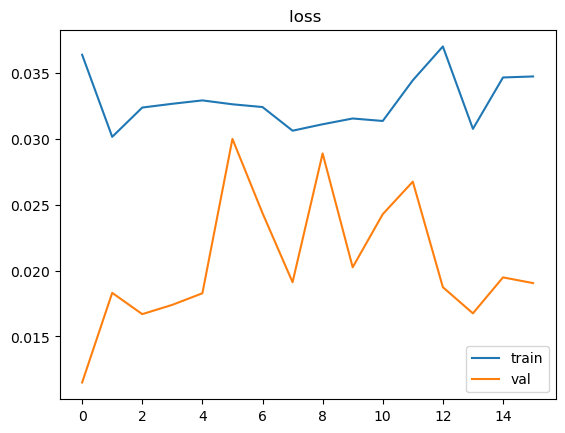

In [45]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('loss ')
plt.legend()
plt.show()

We also show how the trend of the predictions compared to the true values in the test data.

55/55 [==============================] - 0s 808us/step


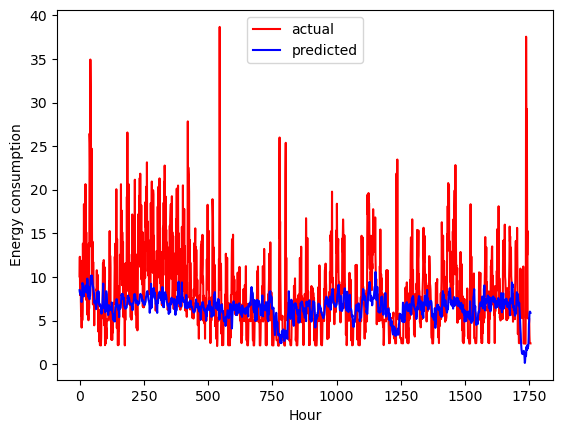

In [47]:
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error
yhat = model.predict(test_lstm_X)

# invert scaling for forecast
inv_yhat = concatenate((yhat, yhat), axis=1)
#inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = y_scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_lstm_y = test_lstm_y.reshape((len(test_lstm_y), 1))
inv_y = concatenate((test_lstm_y, test_lstm_y), axis=1)
inv_y = y_scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

plt.plot(inv_y, color = 'red', label = 'actual')
plt.plot(inv_yhat, color = 'blue', label = 'predicted')
plt.xlabel('Hour')
plt.ylabel('Energy consumption')
plt.legend()
plt.show()

In [50]:
lstm_rmse = mean_squared_error(test_lstm_y, yhat, squared=False)
lstm_mae = mean_absolute_error(test_lstm_y, yhat)
lstm_r2 = r2_score(test_lstm_y, yhat)

print("""
LSTM:
RMSE: {}
MAE: {}
R-squared: {}
""".format(lstm_rmse.round(3), lstm_mae.round(3), lstm_r2.round(3)))


LSTM:
RMSE: 0.017
MAE: 0.011
R-squared: -0.057



The best model is the random forest regressor, as it has low errors while also having a relatively high R-squared value.